# Scalability of sparse matrices

In [1]:
from IPython import get_ipython
if get_ipython():
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

import latenta as la
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [2]:
cells = la.Dim(10000, "cell")
genes = la.Dim(10000, "gene")

In [3]:
value = np.zeros((len(cells), len(genes)))
for i in range(value.shape[0]):
    value[i, np.random.choice(value.shape[1])] = 1.

In [4]:
import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
            if torch.is_tensor(obj):
                size += obj.element_size() * obj.nelement()
        objects = get_referents(*need_referents)
    return size

In [5]:
loader_dense = la.variables.loaders.MemoryLoader(value)
fixed_dense = la.Fixed(loader_dense, definition = la.Definition([cells, genes]))

Obviously, a large difference in memory usage.

In [6]:
getsize(loader_dense)/1024/1024

381.47050285339355

Using 3GB (or more) on current GPUs would be prohibitive.

In [7]:
loader_sparse = la.variables.loaders.SparseDenseMemoryLoader(la.sparse.COO.from_numpy_array(value))
fixed_sparse = la.Fixed(loader_sparse, definition = la.Definition([cells, genes]))

In [8]:
getsize(loader_sparse)/1024/1024

1.5413875579833984

## Timing

When data is accessed from a SparseDenseMemoryLoader, it is converted to a dense tensor. This can cause a slowdown:

In [9]:
import timeit

In [10]:
time = timeit.timeit("loader_dense.get()", number = 1, globals = globals())
time

3.9800070226192474e-06

In [11]:
time = timeit.timeit("loader_sparse.get()", number = 1, globals = globals())
time

0.057309878058731556

Speed is however competitive when subsampling:

In [12]:
idx = {"cell":torch.tensor(range(500))}

In [13]:
time = timeit.timeit("loader_dense.get(idx)", number = 1, globals = globals())
time

0.00218003592453897

In [14]:
time = timeit.timeit("loader_sparse.get(idx)", number = 1, globals = globals())
time

0.003363447031006217

### GPU

Conversion is much faster on a GPU

In [15]:
fixed_sparse.to("cuda")
fixed_dense.to("cuda")

In [16]:
import timeit

In [17]:
idx = {"cell":np.random.choice(len(cells), 1000)}
timeit.timeit("fixed_sparse.loader.get(idx)", number = 3, globals = {"fixed_sparse":fixed_sparse, "idx":idx})

0.0038368440000340343

In [18]:
idx = {"cell":torch.tensor(np.random.choice(len(cells), 500), device = "cuda")}
timeit.timeit("fixed_dense.loader.get(idx)", number = 3, globals = {"fixed_dense":fixed_dense, "idx":idx})

6.793090142309666e-05

### Scalability

The accessing speed scales linearly with the number subsampled elements. Importantly, because of custom indexing in the `la.sparse.COO()` class, it does not scale horrible with higher dataset size:

In [19]:
timings = []
for n_cells in [1e2, 1e3, 1e4, 1e5, 1e6]:
    print(n_cells)
    cells = la.Dim(int(n_cells), "cell")
    genes = la.Dim(10000, "gene")
    
    row = torch.arange(len(cells))
    col = torch.randint(len(genes), size = (len(row), ))
    value = torch.ones(len(row))
    
    coo = la.sparse.COO(row, col, value, shape = (len(cells), len(genes)))
    loader = la.variables.loaders.SparseDenseMemoryLoader(coo)
    fixed = la.Fixed(loader, definition = la.Definition([cells, genes]))
    
    for n_cells_sampled in [100, 200, 500, 1000, 2000, 5000]:
        if n_cells_sampled >= n_cells:
            continue
        idx = {"cell":np.random.choice(len(cells), n_cells_sampled)}
        time = timeit.timeit("loader.get(idx)", number = 1, globals = {"loader":loader, "idx":idx})
        timings.append({"n_cells":n_cells, "n_cells_sampled":n_cells_sampled, "time":time})
timings = pd.DataFrame(timings)

100.0
1000.0
10000.0
100000.0
1000000.0


''

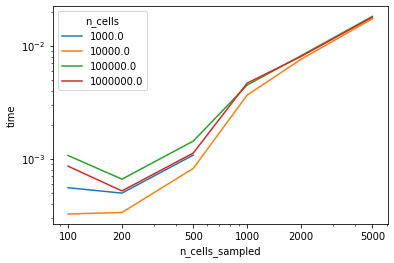

In [20]:
ax = sns.lineplot(x = timings["n_cells_sampled"], y = timings["time"], hue = timings["n_cells"].astype("category"))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks(timings.n_cells_sampled.unique())
ax.set_xticklabels(timings.n_cells_sampled.unique())
;